# Instruction Generator
According the NPC background to generate unique student task instruction

In [1]:
import csv
from io import StringIO
import requests


def get_google_spreadsheet(spreadsheet_id):
    url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv"
    response = requests.get(url, timeout=10)
    if response.status_code == 200:
        csv_str = response.content.decode("utf-8")
        f = StringIO(csv_str)
        spreadsheet_data = []
        reader = csv.reader(f, delimiter=",")
        next(reader, None)  # Skip the header row
        for row in reader:
            if len(row) < 4:
                continue
            name, age, gender, background = row[:4]
            if not name:
                continue
            spreadsheet_data.append(
                {"name": name, "age": age, "gender": gender, "background": background}
            )
        return spreadsheet_data
    return None

In [2]:
from pydantic import BaseModel


class Character(BaseModel):
    name: str
    age: int
    gender: str 
    background: str

npcs = get_google_spreadsheet("1VdQsc9qslvd-gGhydN5dEZEX6Q5uliBQqRguJyHBZM4")
main_character = npcs[0]
if main_character['name'] != 'main_character':
    raise ValueError("The main character's name is not 'main_character'")
main_character = Character(**main_character)

npcs = npcs[1:]
npcs.sort(key=lambda npc: npc['name'])
npcs = [Character(**npc) for npc in npcs]


In [3]:
from langchain_aws import ChatBedrock

model  = ChatBedrock(
    credentials_profile_name="genai",
    model_id="amazon.titan-text-premier-v1:0",
    model_kwargs=dict(temperature=0.5),
    # other params...
)
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = model .invoke(messages)
ai_msg

AIMessage(content='As an AI assistant, I can help you translate sentences from English to French. The sentence "I love programming" can be translated as "J\'aime programmer" in French.', additional_kwargs={'usage': {'prompt_tokens': 23, 'completion_tokens': 37, 'total_tokens': 60}, 'stop_reason': None, 'model_id': 'amazon.titan-text-premier-v1:0'}, response_metadata={'usage': {'prompt_tokens': 23, 'completion_tokens': 37, 'total_tokens': 60}, 'stop_reason': None, 'model_id': 'amazon.titan-text-premier-v1:0'}, id='run-53b4a369-bcbe-4278-8368-ba84132f97a8-0', usage_metadata={'input_tokens': 23, 'output_tokens': 37, 'total_tokens': 60})

In [ ]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field

story_prompt = """
Task: Generate a creative and engaging dialogue between the characters specified below, focused on revealing the background story or personal history of the NPC character.

Instructions:
1. Review the "Topic" and "Characters" sections carefully to understand the context and roles involved.
2. Imagine a natural conversation where the main character "Kube" inquires about the NPC's background or history.
3. Craft two turns of dialogue, with the NPC first providing details about their past, and Kube responding thoughtfully.
4. Ensure each dialogue turn is concise yet expressive, with a maximum of 100 words per character's response.
5. Aim to make the conversation flow naturally while unveiling the NPC's intriguing personal narrative.

Response Format:
NPC Name: (NPC's first dialogue turn revealing background/history details)
Kube: (Kube's insightful response, prompting for more information)
NPC Name: (NPC's second dialogue turn continuing their story)  
Kube: (Kube's final response, reacting to the NPC's revelations)

Context:

Topic: {topic}

Characters: {characters}

Dialogue:

"""

valid_conversation_prompt = """

Task: Evaluate if a given dialogue between an NPC (non-player character) and Kube follows the specified format.

Instructions:
1. Review the dialogue format instructions provided.
2. Carefully read through the entire dialogue provided after the "Dialogue:" section. 
3. Analyze if the dialogue adheres to the format by checking:
    a) The NPC's first turn reveals background/history details
    b) Kube's first response is insightful and prompts for more information
    c) The NPC's second turn continues their story
    d) Kube's final response reacts to the NPC's revelations
4. Respond with only "Yes" or "No" to indicate if the dialogue follows the correct format.

Dialogue Format Instructions:
NPC Name: (NPC's first dialogue turn revealing background/history details)
Kube: (Kube's insightful response, prompting for more information)  
NPC Name: (NPC's second dialogue turn continuing their story)
Kube: (Kube's final response, reacting to the NPC's revelations)

Context:

{dialogue}

Evaluation:
"""


class OverallState(TypedDict):
    topic: str
    main_character: Character
    characters: list[Character]
    conversations: Annotated[list[Character], operator.add]


class StoryState(TypedDict):
    topic: str
    main_character: Character
    character: Character
    conversation: str


def load_characters(state: OverallState):
    return state


def continue_to_story(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send(
            "generate_relationship_conversation",
            {
                "topic": state["topic"],
                "main_character": state["main_character"],
                "character": s,
            },
        )
        for s in state["characters"]
    ]


def generate_relationship_conversation(state: StoryState):
    def print_character(character: Character):
        return f"""

        Name: {character.name}
        Age: {character.age}      
        Background Story: {character.background}
        Gender: {character.gender}
        
        """

    main_character = print_character(state["main_character"])
    character = print_character(state["character"])
    character_str = main_character + character
    # print(character_str)
    prompt = story_prompt.format(topic=state["topic"], characters=character_str)
    response = model.invoke(prompt)
    return {"conversation": [response.content]}


# def valid_conversation(state: StoryState):
#     return {"conversations": [state["conversation"]]}


# def check_conversation_edge(
#     state: StoryState,
# ) -> Literal["generate_relationship_conversation", "valid_conversation"]:
#     dialogue = state["conversation"]
#     prompt = valid_conversation_prompt.format(dialogue=dialogue)

#     response = model.invoke(prompt)
#     if "Yes" in response.content:
#         return "valid_conversation"
#     return "generate_relationship_conversation"


def all_stories(state: OverallState):
    return state


graph = StateGraph(OverallState)
graph.add_node("load_characters", load_characters)
graph.add_node("generate_relationship_conversation", generate_relationship_conversation)
# graph.add_node("valid_conversation", valid_conversation)
graph.add_node("all_stories", all_stories)

graph.add_edge(START, "load_characters")

graph.add_conditional_edges(
    "load_characters", continue_to_story, ["generate_relationship_conversation"]
)
# graph.add_conditional_edges(
#     "generate_relationship_conversation",
#     check_conversation_edge    
# )
# graph.add_edge("valid_conversation", "all_stories")
graph.add_edge("generate_relationship_conversation", "all_stories")

graph.add_edge("all_stories", END)

app = graph.compile()

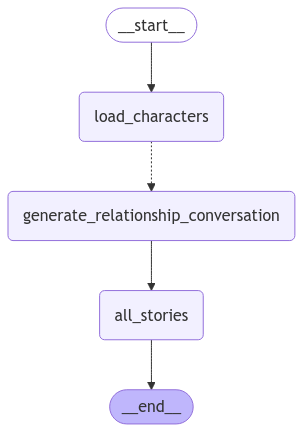

In [84]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [85]:
result = None
main_character.name = "Kube"
characters = npcs[:4]
for s in app.stream(
    input={
        "topic": "Kubernetes Isekai (異世界)",
        "main_character": main_character,
        "characters": characters,
    },
    config={"max_concurrency": 4},
):
    print(s)
    result = s

{'load_characters': {'topic': 'Kubernetes Isekai (異世界)', 'main_character': Character(name='Kube', age=22, gender='Male', background="Tek is a brave warrior who served in the kingdom's army. His family's swordsmanship has made him an outstanding Kubernetes fighter."), 'characters': [Character(name='Aiden', age=28, gender='Male', background='Aiden is a knight loyal to his king and Kubernetes kingdom. His mission is to protect castles and villages from enemy attacks, and he is known for his bravery and loyalty.'), Character(name='Al', age=33, gender='Male', background='Al is a seasoned knight who has earned countless honors in Kubernetes battles. He seeks a trustworthy team to join him in fighting dark forces.'), Character(name='Alice', age=21, gender='Female', background='Alice is a brave female warrior eager to prove herself. She lost her family in a battle and is determined to seek revenge.'), Character(name='Carl', age=31, gender='Female', background='Carl is a scholar who Kubernetes 

InvalidUpdateError: At key 'conversation': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

In [70]:
import os

output_dir = "output/random/"
os.makedirs(output_dir, exist_ok=True)

conversations = result["all_stories"]["conversations"]
for npc, conversation in zip(characters, conversations):
    filename = f"{npc.name}.txt"
    filepath = os.path.join(output_dir, filename)
    with open(filepath, "w") as file:
        file.write(conversation)